![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/florpi/from-zero-to-generative/blob/main/2-generative.ipynb)

In [2]:
#!pip install jax jaxlib flax torchvision torch

In [3]:
# as opposed to pytorch, jax handles device placement automatically
# Now let's check wehther you are actually using a gpu, if so, the output should be a cuda id, otherwise you are using a cpu
import jax
print(jax.devices())

[cuda(id=0)]


In [4]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from torch.utils.data import DataLoader

transform = transforms.Compose(
    (
        transforms.ToTensor(), 
        transforms.Normalize((0.5,), (0.5,)), 
        transforms.Lambda(lambda x: np.transpose(np.array(x), (1,2,0))), 
    )
)
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader = iter(train_dataloader)


# 🎨 From Classification to Generation: Flow Matching

We've mastered classifying digits, but now it's time to flip the script. Instead of recognizing numbers, we're going to create them.

### 🌊 Flow Matching

We're going to learn a process that gradually transforms random noise into digit images. Let's break down the key equations:

1. **Velocity Ordinary Differential Equation (ODE)**:
   At the heart of Flow Matching is this equation:

   $\frac{dx_t}{dt} = v_\theta(x_t, t)$

   Where:
   - $x_t$ is our image as it's being transformed
   - $t$ is time (0 to 1)
   - $v_\theta$ is a velocity field we'll learn (it will be the output of our model)

2. **Linear Interpolation**:
   We chose an x_t that obeys:

   $x_t = (1-t)x_0 + tx_1$

   Where:
   - $x_0$ is random noise (our starting point)
   - $x_1$ is a real digit image (our target) 

3. **Loss Function**:
   We train our model to minimize:

   $L = \mathbb{E}_{t,x_0,x_1} \left[ \left\| v_\theta(x_t, t) - u(x_0,x_1,t) \right\|^2 \right]$

   Where, given the linear interpolant, the true velocity field is $u(x_0, x_1,t) = x_1 - x_0$, This teaches our model to predict the right direction of change at each step.


We'll create a neural network that learns this vector field v. Once trained, we can use it to generate new MNIST-like digits by:
1. Starting with random noise
2. Following the learned flow to transform the noise into a digit


In [5]:
import flax.linen as nn
import jax.numpy as jnp

class VelocityModel(nn.Module):
    backbone: nn.Module
    d_t_embedding: int = 32

    @nn.compact
    def __call__(self, x_t, t,):
        t_embedding = self.get_timestep_embedding(
            t, self.d_t_embedding
        )  
        return self.backbone(x_t, t_embedding,)

    def get_timestep_embedding(self, timesteps, embedding_dim: int, dtype=jnp.float32):
        """Build sinusoidal embeddings (from Fairseq)."""

        assert len(timesteps.shape) == 1
        timesteps *= 1000

        half_dim = embedding_dim // 2
        emb = jnp.log(10_000) / (half_dim - 1)
        emb = jnp.exp(jnp.arange(half_dim, dtype=dtype) * -emb)
        emb = timesteps.astype(dtype)[:, None] * emb[None, :]
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=1)
        if embedding_dim % 2 == 1:  # Zero pad
            emb = jax.lax.pad(emb, dtype(0), ((0, 0, 0), (0, 1, 0)))
        assert emb.shape == (timesteps.shape[0], embedding_dim)
        return emb.squeeze()


Let's modify the MLP used before, since now we will need to output an array of the same shape as our input for the velocity field. In this case, it will be (28,28,1)

In [6]:
#TODO: write architecutre
import numpy as np

class MLP(nn.Module):
    input_shape: tuple  # The shape of the input images

    @nn.compact
    def __call__(self, x, t):
        batch_size = x.shape[0]
        x = x.reshape((batch_size, -1))  # Flatten the input
        x = jnp.concatenate([x, t], axis=-1)
        x = nn.Dense(features=1024)(x)
        x = nn.silu(x)
        x = nn.Dense(features=1024)(x)
        x = nn.silu(x)
        x = nn.Dense(features=1024)(x)
        x = nn.silu(x)
        x = nn.Dense(features=1024)(x)
        x = nn.silu(x)
        # product of input shape: 
        x = nn.Dense(features=np.prod(self.input_shape))(x)
        x = x.reshape((batch_size, *self.input_shape))  # Reshape back to the original image shape
        return x

In [7]:
# turn it into a conditional problem! given class
backbone = MLP(input_shape=(28, 28,1))
velocity_model = VelocityModel(
    backbone=backbone,
    d_t_embedding=64,  
)
# explain randomness and keys



In [8]:
# Let's check that input and output indeed have the same shape
# TODO: Initialize the model and check output and input shapes are the same
key = jax.random.PRNGKey(0)
out, params = velocity_model.init_with_output(
    key, 
    jnp.ones((batch_size,28,28,1)), 
    jnp.array([0.1]*batch_size),
)
print(out.shape)


(64, 28, 28, 1)


In [9]:
import optax
# and let's initialize the optimiser again
learning_rate = 1.e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

In [10]:
# Now let's go back to the flow matching example
# we will first generate samples from xt and plot the trajectories
import equinox as eqx

def pad_t_like_x(t, x):
    if isinstance(t, (float, int)):
        return t
    return jnp.reshape(t, (-1, *([1] * (x.ndim - 1))))

def sample_xt(x0, x1, t):
    t = pad_t_like_x(t, x0)
    # TODO: write down xt
    xt = t * x1 + (1-t) * x0
    return xt

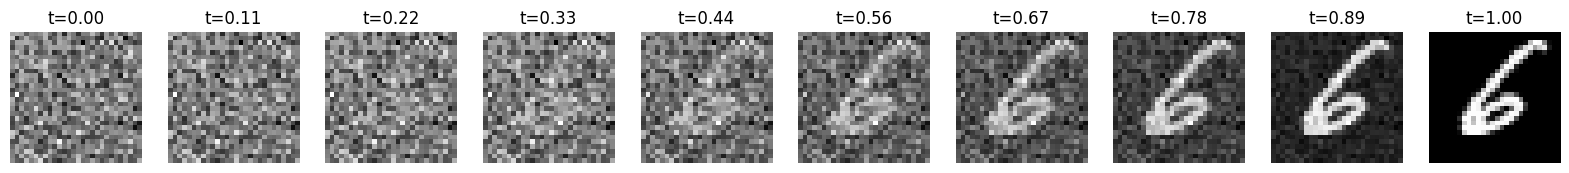

In [11]:
# TODO: Let's plot the trajectories
# Plot trajectories
import matplotlib.pyplot as plt

x_batch, y_batch = next(train_loader)
x_batch = jnp.array(x_batch)

t = jnp.linspace(0, 1, 10)

x0 = jax.random.normal(key, x_batch[0].shape)
x1 = x_batch[3]
xt = jnp.stack([sample_xt(x0, x1, t_) for t_ in t]) 

fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axs):
    ax.imshow(xt[i][:,:,0], cmap='gray')
    ax.axis('off')
    ax.set_title(f't={t[i]:.2f}')

In [12]:
#TODO: Write loss function
# Now let's compute the loss function

def loss_fn(params, x0, x1, t, velocity_model):
    xt = sample_xt(x0, x1, t)
    ut = x1 - x0
    vt = velocity_model.apply(params, xt, t,)
    return jnp.mean((vt-ut)**2)



In [13]:
# and define the training step again


@eqx.filter_jit
def train_step(params, opt_state, x0, x, t_batch, velocity_model, optimizer):
    loss, grads = jax.value_and_grad(loss_fn)(params, x0, x, t_batch,  velocity_model)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [14]:
# sampling solving the ODE

import diffrax as dfx

@eqx.filter_jit
def sample(params, velocity_model, x0, dt:float= 0.01,):
    original_shape = x0.shape
    def velocity(t, x, args):
        x = x.reshape(original_shape)
        t = jnp.atleast_1d(t)
        t = jnp.repeat(t, original_shape[0])
        return velocity_model.apply(params, x, t,).reshape(-1)
    term = dfx.ODETerm(velocity)
    solver = dfx.Euler()
    sol = dfx.diffeqsolve(term, solver, 0., 1., dt, x0.reshape(-1))
    (y,) = sol.ys
    return y.reshape(original_shape)

In [15]:


def plot_image_grid(images, grid_size=(8, 8), figsize=(10, 10), suptitle=None):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            ax.imshow(images[i][:,:,0], cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')
    if suptitle is not None:
        fig.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

Training:   0%|          | 1/6000 [00:01<2:33:15,  1.53s/step, loss=1.9402804]

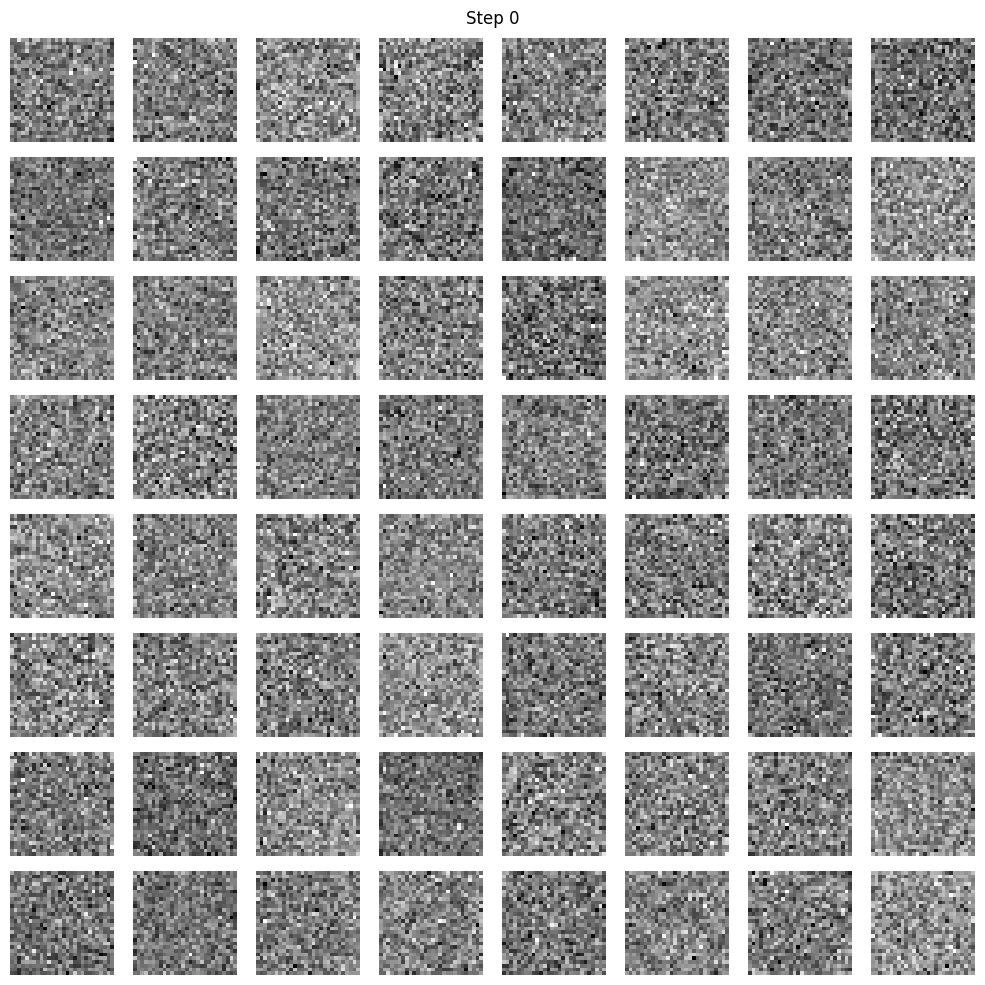

Training:   8%|▊         | 500/6000 [00:16<01:39, 55.18step/s, loss=1.0308181]

In [16]:
from tqdm import tqdm 

num_steps = 6_000
fcn_train_loss = []
with tqdm(total=num_steps, desc='Training', unit='step') as pbar:
    for step in range(num_steps):
        key, subkey1, subkey2 = jax.random.split(key, 3)
        try:
            images, labels = next(train_loader)
        except StopIteration:
            train_loader = iter(train_dataloader)
            images, labels = next(train_loader)
        images, labels = jnp.array(images), jnp.array(labels)
        t_batch = jax.random.uniform(subkey1, (len(images),))
        x0 = jax.random.normal(subkey2, images.shape)
        params, opt_state, loss = train_step(params, opt_state, x0, images, t_batch, velocity_model, optimizer)
        fcn_train_loss.append(loss)
        pbar.set_postfix(loss=loss)
        pbar.update(1)
        if step % 500 == 0:
            x1 = sample(params, velocity_model, x0[:64], dt=0.01)
            plot_image_grid(x1, suptitle=f'Step {step}')

In [ ]:
plt.plot(fcn_train_loss)

In [ ]:
# Let's try a convolutional neural network instead -> add Unet reference
from flax.linen import Conv, ConvTranspose
class ConvBlock(nn.Module):
    features: int

    @nn.compact
    def __call__(self, x):
        x = Conv(features=self.features, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.silu(x)
        x = Conv(features=self.features, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.silu(x)
        return x

class UNet(nn.Module):
    @nn.compact
    def __call__(self, x, t):
        # Downsampling path
        c1 = ConvBlock(features=32)(x)
        c1 = x + t[:,None,None,]
        p1 = nn.max_pool(c1, (2, 2), strides=(2, 2), padding='SAME')
        
        c2 = ConvBlock(features=64)(p1)
        p2 = nn.max_pool(c2, (2, 2), strides=(2, 2), padding='SAME')
        
        b = ConvBlock(features=64)(p2)
        # Upsampling path
       
        u2 = ConvTranspose(features=64, kernel_size=(2, 2), strides=(2, 2))(b)
        u2 = jnp.concatenate([u2, c2], axis=-1)
        u2 = ConvBlock(features=64)(u2)
       
        u1 = ConvTranspose(features=64, kernel_size=(2, 2), strides=(2, 2))(u2)
        u1 = jnp.concatenate([u1, c1], axis=-1)
        u1 = ConvBlock(features=64)(u1)
        
        # Output layer
        outputs = Conv(features=1, kernel_size=(1, 1))(u1)
        
        return outputs



In [ ]:
backbone = UNet()
velocity_model = VelocityModel(
    backbone=backbone,
    d_t_embedding=64,  
)
# explain randomness and keys

key = jax.random.PRNGKey(0)
out, params = velocity_model.init_with_output(
    key, 
    jnp.array(x_batch), 
    jnp.array([0.1]*batch_size),
)
learning_rate = 1.e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

In [ ]:

num_steps = 6_000
cnn_train_loss = []
with tqdm(total=num_steps, desc='Training', unit='step') as pbar:
    for step in range(num_steps):
        key, subkey1, subkey2 = jax.random.split(key, 3)
        try:
            images, labels = next(train_loader)
        except StopIteration:
            train_loader = iter(train_dataloader)
            images, labels = next(train_loader)
        images, labels = jnp.array(images), jnp.array(labels)
        t_batch = jax.random.uniform(subkey1, (len(images),))
        x0 = jax.random.normal(subkey2, images.shape)
        params, opt_state, loss = train_step(params, opt_state, x0, images, t_batch, velocity_model, optimizer)
        cnn_train_loss.append(loss)
        pbar.set_postfix(loss=loss)
        pbar.update(1)
        if step % 500 == 0:
            x1 = sample(params, velocity_model, x0[:64], dt=0.01)
            plot_image_grid(x1, suptitle=f'Step {step}')

In [ ]:
plt.plot(fcn_train_loss)
plt.plot(cnn_train_loss)

In [ ]:
# try classifier on generated samples, how does the loss correlate with classifier accuracy? Some times small differences on loss are not big differences in perception!
# how would you build a conditional generative model so that we chose to generate just 2's or 8's?